# WLAN Fingerprint-based Indoor Localization

In this notebook, I begin from the raw UJIIndoorLoc dataset and perform an initial exploratory data analysis on the distributions of the predictors and response variables. This is followed by dimensionality reduction analysis. Once the data is prepared, I focus on the model selection and finally ensemble learning.

## Table of Contents

* [Dataset Description](#dataset-description)

* [Predictor Data Exploration](#eda)

* [Missing Value Imputation](#missing-value-imputation)

* [Box-Cox Transformation](#box-cox)

* [Predictor Correlations](#predictor-correlations)

* [Principal Component Analysis (PCA)](#pca)

In [44]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [45]:
train_data = pd.read_csv("data/trainingData.csv")
test_data = pd.read_csv("data/validationData.csv")

# Dataset Description <a id='dataset-description'></a>

Source: https://www.kaggle.com/giantuji/UjiIndoorLoc

- **WAP001-WAP520**: Intensity value for **Wireless Access Point** (AP). AP will be the acronym used for rest of this notebook. Negative integer values from -104 to 0 and +100. **Censored data:** Positive value 100 used if WAP was not detected.

- **Longitude**: Longitude. Negative real values from -7695.9387549299299000 to -7299.786516730871000

- **Latitude**: Latitude. Positive real values from 4864745.7450159714 to 4865017.3646842018.

- **Floor**: Altitude in floors inside the building. Integer values from 0 to 4.

- **BuildingID**: ID to identify the building. Measures were taken in three different buildings. Categorical integer values from 0 to 2.

- **SpaceID**: Internal ID number to identify the Space (office, corridor, classroom) where the capture was taken. Categorical integer values.

- **RelativePosition**: Relative position with respect to the Space (1 - Inside, 2 - Outside in Front of the door). Categorical integer values.

- **UserID**: User identifier (see below). Categorical integer values.

- **PhoneID**: Android device identifier (see below). Categorical integer values.

- **Timestamp**: UNIX Time when the capture was taken. Integer value.

In [46]:
train_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [47]:
train_data.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [48]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
(train_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']]
.astype(str)
.describe(include=['object']))

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


From the [paper](http://ieeexplore.ieee.org/document/7275492/) on this dataset:
"Although both the training subset and the validation subset contain the same information, the latter includes the value 0 in some fields. These fields are: SpaceID, Relative Position with respect to SpaceID and UserID. As it has been commented before, this information was not recorded because the validation captures were taken at arbitrary points and the users were not tracked in this phase. **This fact tries to simulate a real localization system.**"

Hence, Space ID, Relative Position, User ID won't be used to model the Localization algorithm. Also, Phone iD won't be used as in a real system, new phones should be localized without being used in the training.

Next, I focus on the pre-processing of the WAP RSSI columns.

# Predictor Data Exploration <a id='eda'></a>

In [49]:
X_train = train_data.iloc[:,:520]
X_test = test_data.iloc[:,:520]

y_train = train_data.iloc[:,520:526]
y_test = test_data.iloc[:,520:526]

In [50]:
X_train.shape

(19937, 520)

In [51]:
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_test = (X_test
             .replace(to_replace=100,value=np.nan))

We are replacing the out-of-range values with NaN to avoid disturbance to our analysis on in-range RSSI distribution.

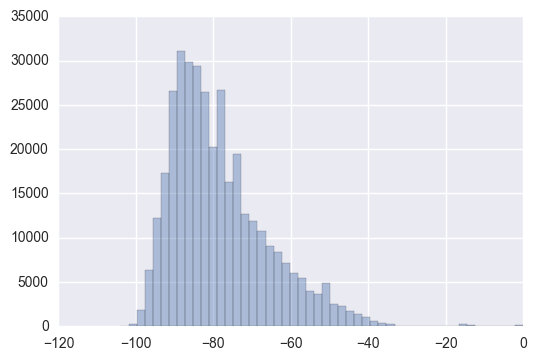

In [52]:
X_stack = X_train.stack(dropna=False)
sns.distplot(X_stack.dropna(),kde = False)

In the above figure, majority of the RSSI values are present in the (-95dBm,-80dBm) range. Clearly, the distribution is right-skewed with majority of the values in the left side of the distribution.

Interestingly, the highest RSSI value is 0 dBm which is clearly an outlier. Usually, when a device receives from multiple APs, it associates with the AP that provides the highest RSSI. Therefore, I next analyze the distribution of the highest RSSI per sample.

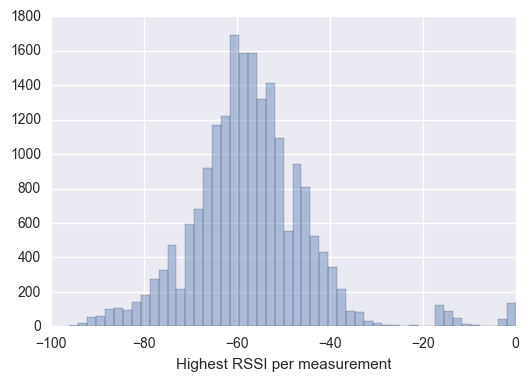

In [53]:
X_ap_max = (X_train
           .max(axis = 1,skipna=True)
           .dropna())

fig, ax = plt.subplots(1,1)

sns.distplot(X_ap_max.dropna(), ax = ax,kde=False)
ax.set_xlabel("Highest RSSI per measurement")

**Skewness:** For normally distributed data, the skewness should be about 0. A skewness value > 0 means that there is more weight in the left tail of the distribution. Similarly, a negative value indicates a left-skewed distribution with more weight on the right tail.

In [54]:
print("Skewness of entire RSSI distribution", X_stack.skew())
print("Skewness of max RSSI distribution", X_ap_max.skew())

Skewness of entire RSSI distribution 1.15555277437
Skewness of max RSSI distribution 0.896459494047


Expectedly, the center of the distribution of the max RSSI per sample is higher than the entire distribution. Also, it looks more normal which is validated by the reduction in Skewness value from 1.155 to 0.896.

I expect just a few APs (2-3) in range for any measurement. What does the data say?

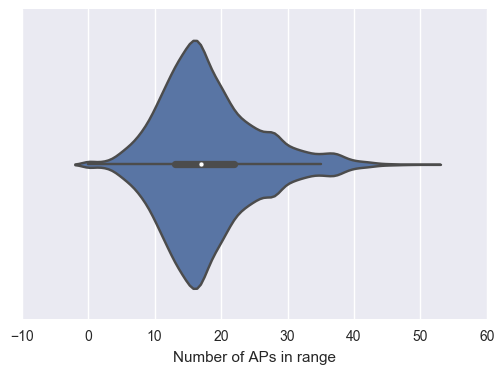

In [55]:
aps_in_range = (X_train
                 .notnull()
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)

sns.violinplot(aps_in_range, ax = ax)
ax.set_xlabel("Number of APs in range")

1. Interestingly, majority of the samples have over 13 APs in range with the maximum of 51 APs. Although 51 is the maximum, it is clearly an outlier based on the density displayed in the violin plot. 

2. 13 APs corresponds to less than 3% of all the APs in our dataset.


3. We do observe some of the training samples with 0 APs in range. Let's remove these samples from the training data.

In [56]:
print("Before sample removal:", len(X_train))

y_train = (y_train
          .loc[X_train
              .notnull()
              .any(axis=1),:])

X_train = (X_train
           .loc[X_train
                .notnull()
                .any(axis=1),:])

print("After sample removal:", len(X_train))

Before sample removal: 19937
After sample removal: 19861


In [57]:
1300/520

2.5

We can remove the RSSI columns related to APs which are not in range in any of our training samples as there is no useful information contained in this data.

In [58]:
# Removing columns with all NaN values
all_nan = (X_train
           .isnull()
           .all(axis=0) == False)
filtered_cols = (all_nan[all_nan]
                 .index
                 .values)

print("Before removing predictors with no in-range values", X_train.shape)

X_train = X_train.loc[:,filtered_cols]
X_test = X_test.loc[:,filtered_cols]

print("After removing predictors with no in-range values", X_train.shape)

Before removing predictors with no in-range values (19861, 520)
After removing predictors with no in-range values (19861, 465)


# Missing Value Imputation <a id="missing-value-imputation"></a>

We need to fill in the missing values before we can apply any of the machine learning models. How do we fill the missing values? Should we simply equate it with the absolute lowest value in our dataset? Or, should we estimate the distributuon of each predictor and randomly sample from the left tail?

Before we can answer such questions, we need to understand how much of our data is missing.

In [59]:
# Proportion of out of range values
sum(X_stack.isnull() == 0)/len(X_stack)

0.034605449473533938

**96.1% of the values in the matrix represent Out-of-Range.** This is expected as for any given measurement, only a small subset of the APs are in range of the mobile device location as we observed in the previous section.

Let us analyze the missing data percentage for different predictors.

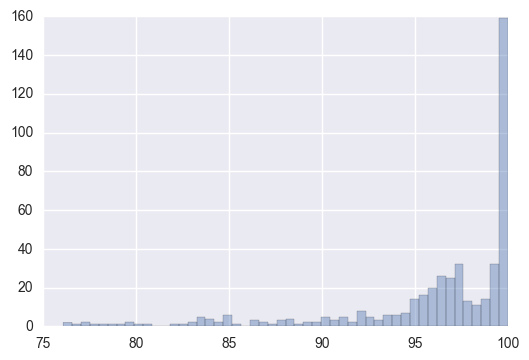

In [67]:
miss_perc = (X_train
            .isnull()
            .sum(axis=0))

miss_perc *= 100/len(X_train)

sns.distplot(miss_perc,bins = 50,kde=False)

Interestingly, **160 of the predictors have more than 99.5% of the values missing!** I got useful advice from [/u/DrLionelRaymond](https://www.reddit.com/r/MLQuestions/comments/62qnlv/skewness_kurtosis_and_boxcox_for_censored_data/) on how to fill the missing values. Simple single value imputation (e.g., absolute minimum value) is fine when the amount of missing data is low, but for over 85% missing data using a single value might introduce significant bias. One approach is Maximum Likelihood Estimator based imputation which is indeed more robust but it's performance drops quite a bit for missingness approaching 80%.

Rubin has published extensively on the distribution based approach and Chen has done a lot of work on the Bayesian approach. **It's important to point out that when performing the imputation you want the imputed values match the underlying distribution.** 

For this purpose, it's important to understand the distribution of our predictor. The null hypothesis is that each predictor has a normal distribution. Let's find out how far the distributions are from normal using the following measures, Skewness and Kurtosis.

**Skewness:** For normally distributed data, the skewness should be about 0. A skewness value > 0 means that there is more weight in the left tail of the distribution. Similarly, a negative value indicates a left-skewed distribution with more weight on the right tail.

**Kurtosis:** Kurtosis is the fourth central moment divided by the square of the variance. If a distribution has  positive kurtosis, that means it has more in the tails than the normal distribution. Similarly, if a distribution has a negative kurtosis, it has less in the tails than the normal distribution. 

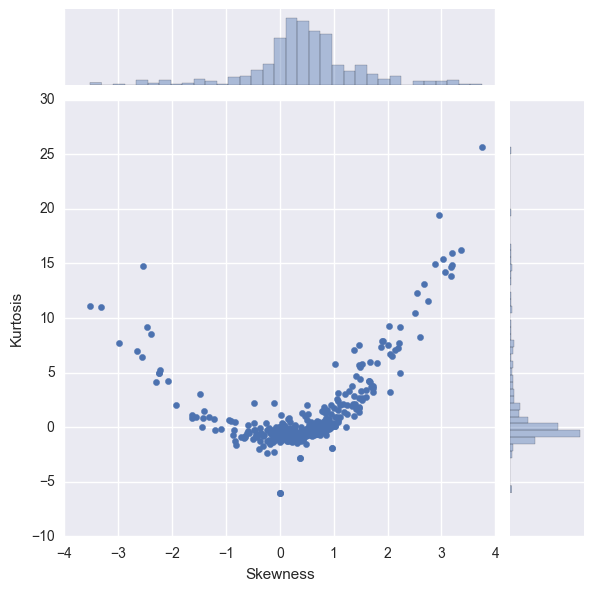

In [77]:
# Skewness of the predictors ignoring out-of-range values
X_skew = X_train.skew()
X_kurtosis = X_train.kurtosis()

g = sns.jointplot(y=X_kurtosis, x=X_skew, stat_func= None)
g.set_axis_labels('Skewness','Kurtosis')

Clearly, the skewness and kurtosis values for most predictors are in the range of (-1,1) indicating closeness to normality. Based on this, we can estimate a Gaussian kernel for each of our predictors to fill the missing values.

## Kernel Density Estimation <a id="kde-estimation"></a>

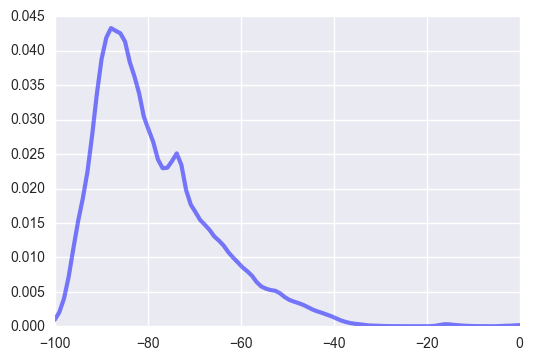

In [120]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-100, 0, 100)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.array(X_train.stack().dropna())

kde_skl = KernelDensity(bandwidth=1.0,rtol=1e-4)
kde_skl.fit(x[:, np.newaxis])
# score_samples() returns the log-likelihood of the samples
log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
plt.plot(x_grid, np.exp(log_pdf), color = 'blue',alpha = 0.5, lw = 3)
#plt.fill(x_grid, pdf_true,ec='gray',fc='gray',alpha=0.4)

In [132]:
z = kde_skl.sample(n_samples=1000000)

[k for k in z if k <=abs_min]

[array([-104.37849335]),
 array([-104.07743163]),
 array([-105.56910134]),
 array([-105.00530509]),
 array([-104.90035907]),
 array([-105.61528094]),
 array([-104.35544041]),
 array([-104.09101559]),
 array([-105.14568299]),
 array([-105.3331787]),
 array([-104.1812739]),
 array([-104.02959812]),
 array([-105.55654843])]